In [1]:
import datetime
tme = datetime.datetime.utcnow()+datetime.timedelta(hours=2)
print(tme.strftime('%H:%M:%S'))

13:59:32


In [2]:
Direct_Detection = True
DP_Weights_Path = "/content/drive/MyDrive/YoloWeights/Yolo5/yolo5s-2CWs320-trs320-vm7.pt"

In [3]:
# Deletion of any non empty folder

#import shutil
#shutil.rmtree('') # put the path you want to delete

# Set initial path

%cd /content

/content


In [4]:
running_on_vm = True
#false --> running on colab
#true  --> running on vm

In [5]:
delete_previous_data_set = True
# in case of running on vm
  #false --> keep previous dataset that was downloaded from robowflow
  #true  --> delete previous dataset

In [6]:
code_exists_on_vm = False
# in case of running on vm
  #false --> download the code or modify it from github
  #true  --> dont download code from github or modify it

In [7]:
if running_on_vm:
  mainfolderpath = '/content/YOLO'
else:
  mainfolderpath = '/content'
%cd $mainfolderpath

/content/YOLO


In [8]:
import shutil
if running_on_vm:
    try:
        shutil.rmtree('yolov5/runs')
    except:
        No_Error = 0

In [9]:
if running_on_vm and (not(code_exists_on_vm)) :
    try:
        shutil.rmtree('yolov5')
    except:
        No_Error = 0

In [10]:
#MOUNT GOOGLE DRIVE
if not running_on_vm:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [11]:
import warnings;
warnings.filterwarnings('ignore');

In [12]:
YOLO_Conf_Thresh = .15
YOLO_Overlap_Thresh = .45
YOLO_Epochs = 1000
YOLO_Early_Stopping = 100  # 0 for no early stopping

YOLO_imgsize = 320
YOLO_batch = 32

# YOLO Info

italicized text# How to Train YOLOv5 on Custom Objects

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train YOLOv5 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference



### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)



#Importing

In [13]:
from google.colab import files
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from google.colab.patches import cv2_imshow
import numpy as np
import seaborn as sns

from __future__ import print_function, division


import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

import csv
import requests
import xml.etree.ElementTree as ET
import cv2
import shutil
from IPython.display import clear_output

In [14]:
"""
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6
"""
if not running_on_vm or (running_on_vm and not code_exists_on_vm):
    try:
        shutil.rmtree(mainfolderpath + '/yolov5')
    except:
        No_Error = 0
    !git clone https://github.com/ultralytics/yolov5  # clone
    #!git clone https://github.com/Ahbassetsh/yolov5  # clone

%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 60.0/186.0 GB disk)


# Download Correctly Formatted Custom Dataset

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).



![YOLOv5 PyTorch export](https://i.imgur.com/5vr9G2u.png)


# Dataset Configuration and Initial Weights


In [15]:
#init_yolo = "yolov5s.pt"   # dummy weights for non pretrained
#init_yolo = "/content/drive/MyDrive/YoloWeights/yolov5s6.pt"   # --> from drive for Pretrained weights with "imagenet", network s6
#init_yolo = "/content/drive/MyDrive/YoloWeights/yolov5m6.pt"   # --> from drive for Pretrained weights with "imagenet" , network m6
init_yolo = "/content/drive/MyDrive/YoloWeights/yolov5s.pt" # coco , network s
#init_yolo = "/content/drive/MyDrive/YoloWeights/yolov5n.pt" # coco , network n
#init_yolo = "/content/drive/MyDrive/YoloWeights/yolov5m.pt" # coco , network m

#init_yolo = "Custom path"  # --> write custom path here

In [16]:
#class_names = ['Gun']
#class_names = ['Weapon']
class_names = ['Gun' , 'LongGun']
#class_names = ['Gun' , 'LongGun' , 'PartialGun']
#class_names = ['Gun' , 'LongGun' , 'NotGun', 'PartialGun']

#class_names = ['Face']
#class_names = ['with_mask' , 'without_mask' , 'mask_weared_incorrect']  not used with small initials due to order in cofusion matrix is alphabetical (dummy is small initial to be always the last)
#class_names = ['Mask_weared_incorrect' , 'With_mask' , 'Without_mask' , ] # classes is  labeled by its number , not name, so no problem for change initials to capital

num_of_classes = len(class_names)
print(num_of_classes)

2


In [17]:
import shutil
import os

%cd $mainfolderpath

if running_on_vm and delete_previous_data_set:
    try:
        shutil.rmtree('train')
        shutil.rmtree('test')
        shutil.rmtree('valid')
        os.remove('README.dataset.txt')
        os.remove('README.roboflow.txt')
        os.remove('data.yaml')
    except:
        No_Error = 0

/content/YOLO


In [18]:
if (not running_on_vm) or (running_on_vm and delete_previous_data_set):

  #Dataset 1 class:
  if num_of_classes ==1:
    #DS1CFace- Original
    #!curl -L "https://app.roboflow.com/ds/Ta3ZuCz3nh?key=tlmDfUD8sr" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS1 mini - 0 Original    [892]
    #!curl -L "https://app.roboflow.com/ds/DZXNaYaMDv?key=TFnRmq6EGK" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 mini - 1 Augm        [2142]
    #!curl -L "https://app.roboflow.com/ds/Yugj7EsqVp?key=BGC5JRoVir" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 mini - 2 Augm Blur   [2142]
    #!curl -L "https://app.roboflow.com/ds/6ZwCWrb5YQ?key=AIPCtcwt1V" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 mini - 3 Augm Noise  [2142]
    #!curl -L "https://app.roboflow.com/ds/okBMatCcLc?key=sh78iKEUae" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS1 full - 0 Original    [2971]
    #!curl -L "https://app.roboflow.com/ds/d27tX4Tsyi?key=LHaM7Pz2VP" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 full - 1 Augm        [7131]
    #!curl -L "https://app.roboflow.com/ds/2tPjmCTXdJ?key=GEEeyT7ATS" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 full - 2 Augm Blur   [7131]
    #!curl -L "https://app.roboflow.com/ds/S3iQDOb38a?key=xaiKB6BIKE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 full - 3 Augm Noise  [7131]
    #!curl -L "https://app.roboflow.com/ds/j9PDHIvJ9g?key=iWZVXEn5Ba" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DSW1 - 0 Original [2020]-2 images new-2389 instances
    !curl -L "https://app.roboflow.com/ds/Uy0p7zqv8c?key=zSXEovmzIQ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSW1 - 0 Original [2020] images new-2380 instances
    #!curl -L "https://app.roboflow.com/ds/IL3OuUMwc9?key=V5hHQCzhDj" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSW1 - 0 Original [2020] images - old deleted
    #!curl -L "https://app.roboflow.com/ds/K24gaje1Br?key=rXD8tHioDa" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSW1 - 0 Original        [2067]
    #!curl -L "https://app.roboflow.com/ds/JUZcrDan8k?key=sUILHztMLA" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSW1 - 1 Augm            [3512] - old deleted
    #!curl -L "https://app.roboflow.com/ds/c0PqTxDfiG?key=F2GVqBp9dg" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSW1 - 2 Augm Blur
    #!curl -L "" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSW1 - 3 Augm Noise
    #!curl -L "" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  #Dataset 2 Classes:
  if num_of_classes ==2:
    #DS2CW- 0 Original-S320        [2020]-2
    !curl -L "https://app.roboflow.com/ds/qFJTBkQkFI?key=XnCMMthRTQ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS2CW- 0 Original-S448        [2020]-2
    #!curl -L "https://app.roboflow.com/ds/kqJBryzIPo?key=0jhBufOnTn" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS2CW- 0 Original-S640        [2020]-2
    #!curl -L "https://app.roboflow.com/ds/15OEe6WAbb?key=iXZbEA6wIZ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS2CW- 0 Original        [2020]
    #!curl -L "https://app.roboflow.com/ds/BEsYJthyCg?key=OzELo1fx7W" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DSG2 - 0 Original        [1568]
    #!curl -L "https://app.roboflow.com/ds/b08m11oX6U?key=lv8sgLBRNq" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSG2 - 1 Augm            [3778]
    #!curl -L "https://app.roboflow.com/ds/XA80St7JCu?key=jdQY4NeRDj" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSG2 - 2 Augm Blur
    #!curl -L "" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSG2 - 3 Augm Noise
    #!curl -L "" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  #Dataset 3 Classes:
  if num_of_classes ==3:
    #DS3CFace- Original
    !curl -L "https://app.roboflow.com/ds/zHVGdYkiJj?key=GYaTug9xIw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3CW- 0 Original        [2020]-2
    #!curl -L "https://app.roboflow.com/ds/0j9Pn4MCZ4?key=ukwMJ9XET4" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3CW- 0 Original        [2020]
    #!curl -L "https://app.roboflow.com/ds/8VgCuytJ62?key=g3Dcrc2cx4" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS3 - 0 Original Balance [1596]
    #!curl -L "https://app.roboflow.com/ds/lIbyLUIz7D?key=8C5aw7suSh" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3 - 0 Augm Balance     [3841]
    #!curl -L "https://app.roboflow.com/ds/3C1Ge2kAS4?key=VGmFElZTdm" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS3 - 0 Original
    #!curl -L "https://app.roboflow.com/ds/uiNpxoDdUs?key=exz831vMZz" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3 - 1 Augm
    #!curl -L "https://app.roboflow.com/ds/LvMGQzLES0?key=6ANGFpxV4A" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3 - 2 Augm Blur
    #!curl -L "https://app.roboflow.com/ds/WObMXtfHfs?key=oSl4WnjUYv" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3 - 3 Augm Noise
    #!curl -L "https://app.roboflow.com/ds/TErt9hwwip?key=R3zUnzFA2W" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  #Dataset 4 Classes:
  if num_of_classes ==4:
    #DS4 - 0 Original Balance [1599]
    !curl -L "https://app.roboflow.com/ds/LwaUHPRqG9?key=6jqGV0fnSL" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS4 - 0 Augm Balance     [3809]
    #!curl -L "https://app.roboflow.com/ds/AYtjRHgDAR?key=wDWc1Lh1E8" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS4 - 0 Original
    #!curl -L "https://app.roboflow.com/ds/QHCLbNabyM?key=acVqMYm7sV" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS4 - 1 Augm
    #!curl -L "https://app.roboflow.com/ds/b9xg1NJXys?key=wEOzoBV21g" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS4 - 2 Augm Blur
    #!curl -L "https://app.roboflow.com/ds/QAHbD0HaXD?key=jkbV2eEp0f" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS4 - 3 Augm Noise
    #!curl -L "https://app.roboflow.com/ds/8gmcgzNLsY?key=yWmU8PhWZa" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
 #!curl -L "" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   911  100   911    0     0   3057      0 --:--:-- --:--:-- --:--:--  3057
100 25.2M  100 25.2M    0     0  18.7M      0  0:00:01  0:00:01 --:--:-- 49.2M
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/10098CG_jpg.rf.cf62bd4aef94182967f201fbe979dbbf.jpg  
 extracting: test/images/10102EP_jpg.rf.2dac0d6840ef28e9346b79832d7cf85c.jpg  
 extracting: test/images/10115CG_jpg.rf.7d7d233120fdfec6d00f9ea4ccf1dff2.jpg  
 extracting: test/images/10130CG_jpg.rf.dbfa7bda8a6ce61535d62898652182a5.jpg  
 extracting: test/images/10144DL_jpg.rf.82e5a0ac42b07e48301b44894721c686.jpg  
 extracting: test/images/10198DG_jpg.rf.bcddf754f535a55adc4eddbb851baefb.jpg  
 extracting: test/images/103

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

# Train

In [19]:
import datetime
tme = datetime.datetime.utcnow()+datetime.timedelta(hours=2)
print(tme.strftime('%H:%M:%S'))

14:00:00


In [20]:
# train yolov5s on custom data for 1000 epochs

# time its performance
%%time

gopath=mainfolderpath + '/yolov5/'
%cd $gopath

if not running_on_vm or (running_on_vm and not code_exists_on_vm):
  with open('train.py') as f:
    model_file = f.read()

  with open('train.py', 'w') as f:
    model_file = model_file.replace("torch.save(ckpt, best)","torch.save(ckpt, best)\n" + "                    print('\\n_____________________________________________NEW BEST at epoch (' + str(epoch) + ')\\n')")
    f.write(model_file)

# Non-Pre-Trained & # Pre-Trainned: (according to path)
patience =  YOLO_Early_Stopping
dPatht =  mainfolderpath + '/data.yaml'
if not Direct_Detection:
    !python train.py --img $YOLO_imgsize --batch $YOLO_batch --epochs $YOLO_Epochs --data $dPatht --weights $init_yolo --name yolov5s_results  --cache --patience $patience

/content/YOLO/yolov5
CPU times: user 3.8 ms, sys: 0 ns, total: 3.8 ms
Wall time: 5.45 ms


In [21]:
import datetime
tme = datetime.datetime.utcnow()+datetime.timedelta(hours=2)
print(tme.strftime('%H:%M:%S'))

14:00:00


# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

# Evaluation Graphs

In [22]:
#!kill 43578
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
tbPath = mainfolderpath + '/yolov5/runs'
%tensorboard --logdir $tbPath

Reusing TensorBoard on port 6006 (pid 56523), started 510 days, 18:33:25 ago. (Use '!kill 56523' to kill it.)

<IPython.core.display.Javascript object>

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

# Model Reconfiguration

In [23]:
gopath=mainfolderpath + '/yolov5/'
%cd $gopath

/content/YOLO/yolov5


In [24]:
if not running_on_vm or (running_on_vm and not code_exists_on_vm):
  with open('val.py') as f:
    model_file = f.read()

  with open('val.py', 'w') as f:
    model_file = model_file.replace("confusion_matrix.plot(save_dir=save_dir, names=list(names.values()))",
                                    "confusion_matrix.plot(save_dir=save_dir, names=list(names.values()))\n"+
                                    "        cm = confusion_matrix.matrix\n        f = open(str(save_dir)+'/ConfusionMatrix.txt', 'w')\n"+
                                    "        f.write(np.array2string(cm))\n        f.close()")


    model_file = model_file.replace("for i, c in enumerate(ap_class):\n        maps[c] = ap[i]",
                                    "for i, c in enumerate(ap_class):\n        maps[c] = ap[i]\n"+
                                    "    f = open(str(save_dir)+'/ConfusionMatrix.txt', 'a')\n"+
                                    "    f.write('\\n'+str(map50))\n    f.write('\\n' + str(map))\n    f.close()")
    f.write(model_file)



In [25]:
exp = 0

In [26]:
#extract class images with "yolo format"
def extract_images(xml_path,image_Size,get_conf = False,get_all_conf = False):
  global num_of_classes
  N = num_of_classes
  file1 = open(xml_path, 'r')
  Lines = file1.readlines()
  classes = []
  X_C = []
  Y_C = []
  Width = []
  Hight = []
  Confidences = []
  ALL_Conf = []
  ctr = 0
  for l in Lines:
    ALL_Conf.append([N/(i+3*N) for i in range(N)])
    classes.append(int(l.strip().split(' ')[0]))
    X_C.append(float(l.strip().split(' ')[1])*image_Size[1])
    Y_C.append(float(l.strip().split(' ')[2])*image_Size[0])
    Width.append(float(l.strip().split(' ')[3])*image_Size[1])
    Hight.append(float(l.strip().split(' ')[4])*image_Size[0])
    if get_conf or get_all_conf:
        Confidences.append(float(l.strip().split(' ')[5]))
        ALL_Conf[ctr] = [i*float(l.strip().split(' ')[5]) for i in ALL_Conf[ctr]]
        ALL_Conf[ctr][int(l.strip().split(' ')[0])] = float(l.strip().split(' ')[5])
    ctr = ctr+1

  i = 0
  xmin = []
  xmax = []
  ymin = []
  ymax = []
  while i< len(X_C):
    xmin.append(int(X_C[i] - Width[i]/2.0))
    xmax.append(int(X_C[i] + Width[i]/2.0))
    ymin.append(int(Y_C[i] - Hight[i]/2.0))
    ymax.append(int(Y_C[i] + Hight[i]/2.0))
    i = i + 1

  if get_all_conf:
      return classes,xmin,xmax,ymin,ymax,Confidences,ALL_Conf
  if get_conf:
      return classes,xmin,xmax,ymin,ymax,Confidences
  return classes,xmin,xmax,ymin,ymax

In [27]:
def Get_Stats(Cor_List, Com_List):
      # print separate classes metrics from the report and stop before dummy:
      repo = classification_report(Cor_List,Com_List).splitlines()
      PR = []
      RE = []
      F1s = []
      print(repo[0])
      for ele in repo[2:]:
          if 'dummy' in ele:
              break
          else:
              print(ele) #print the line from report
              metrics_list = ele.split(' ')
              metrics_list = [mm for mm in metrics_list if mm]
              PR.append(float(metrics_list[1])) #classes should be of one word (No_spaces)
              RE.append(float(metrics_list[2]))
              F1s.append(float(metrics_list[3]))

      avgP = round(sum(PR)/len(PR),3)
      avgR = round(sum(RE)/len(PR),3)
      M5I = round(.99*(float(avgP) + float(avgR))/2,3)
      M9I = round(.7*(float(avgP) + float(avgR))/2,3)
      M5 = round(.9*(float(avgP) + float(avgR))/2,3)
      M9 = round(.5*(float(avgP) + float(avgR))/2,3)
      avgF = round(sum(F1s)/len(PR),3)

      idx_ctr = 0
      correct_ctr = 0
      All_ctr = 0
      for ele in Cor_List:
          if Cor_List[idx_ctr] == Com_List[idx_ctr]:#old--> and Cor_List[idx_ctr] != 'dummy':
              correct_ctr += 1
              All_ctr += 1
          else:#old-->if Cor_List[idx_ctr] != 'dummy':
              All_ctr += 1
          idx_ctr += 1


      acc = round(((correct_ctr/All_ctr)),3)
      return acc, avgP, avgR, avgF, M5I, M9I, M5, M9

In [28]:
def yolo_Matrix(valid_test, yolo_weights_path = mainfolderpath + '/yolov5/runs/train/yolov5s_results/weights/best.pt'):# valid_test = 0 ->validation///valid_test = 1 ->test
      global exp
      test_path = ""
      if valid_test == 0:
          test_path = mainfolderpath + '/valid/images'
      elif valid_test == 1:
          test_path = mainfolderpath + '/test/images'


      exp = exp + 1
      if exp ==1:
            exp_path = mainfolderpath + '/yolov5/runs/detect/exp'
            labels_path = mainfolderpath + '/yolov5/runs/detect/exp/labels'
      else:
            exp_path = mainfolderpath + '/yolov5/runs/detect/exp' + str(exp)
            labels_path = mainfolderpath + '/yolov5/runs/detect/exp' + str(exp) + '/labels'

      go_path = mainfolderpath + '/yolov5'
      %cd $go_path
      !python detect.py --weights $yolo_weights_path --img $YOLO_imgsize --conf 0.4 --source $test_path --save-txt --save-conf --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh
      %cd $mainfolderpath


      original_classes = []
      pred_classes = []
      for img_name in os.listdir(test_path):
          file_path = os.path.join(test_path,img_name)
          img_shape = cv2.imread(file_path).shape
          txt_path = ""
          if valid_test == 0:
              txt_path = os.path.join(mainfolderpath + '/valid/labels',img_name[:-3]+"txt")
          elif valid_test == 1:
              txt_path = os.path.join(mainfolderpath + '/test/labels',img_name[:-3]+"txt")
          actual_classes,actual_xmin,actual_xmax,actual_ymin,actual_ymax = extract_images(txt_path,img_shape)



          txt_path = os.path.join(labels_path,img_name[:-3]+"txt")
          yolo_classes = []
          try:
            yolo_classes,yolo_xmin,yolo_xmax,yolo_ymin,yolo_ymax,yolo_confidences,Image_all_YOlO_Confs = extract_images(txt_path,img_shape,True, True)
          except:
            yolo_classes,yolo_xmin,yolo_xmax,yolo_ymin,yolo_ymax,yolo_confidences,Image_all_YOlO_Confs = [],[],[],[],[],[],[]

          Final_classes = []
          i = 0
          isub_ctr = -1
          original_im = cv2.imread(file_path)
          for sub_img in yolo_xmin:
              isub_ctr = isub_ctr + 1
              clear_output(wait=False)
              Yolo_class = int(yolo_classes[i])
              Final_class = int(Yolo_class)
              Final_classes.append(Final_class)
              i = i+1

          Not_Found_actual = []
          for act_cls in actual_classes:
              # check if the actual class is in the Final_classes
              # and delete it if so:
              ind_ctr = 0
              found = False
              while ind_ctr < len(Final_classes):
                  if act_cls == Final_classes[ind_ctr] and act_cls != num_of_classes:
                      original_classes.append(class_names[act_cls])
                      pred_classes.append(class_names[Final_classes[ind_ctr]])
                      del Final_classes[ind_ctr]
                      found = True
                      break
                  ind_ctr = ind_ctr + 1
              if not found:
                  if act_cls != num_of_classes:
                      Not_Found_actual.append(act_cls)

          rem_act_ctr = 0
          rem_pre_ctr = 0
          while rem_act_ctr < len(Not_Found_actual):
              if Not_Found_actual[rem_act_ctr]!= num_of_classes:
                  original_classes.append(class_names[Not_Found_actual[rem_act_ctr]])
                  if rem_pre_ctr < len(Final_classes) and Final_classes[rem_pre_ctr] != num_of_classes:
                      pred_classes.append(class_names[Final_classes[rem_pre_ctr]])
                      del Final_classes[rem_pre_ctr]
                  elif rem_pre_ctr < len(Final_classes):
                      pred_classes.append('dummy')
                      del Final_classes[rem_pre_ctr]
                  else:
                      pred_classes.append('dummy')
              else:
                  if rem_pre_ctr < len(Final_classes) and Final_classes[rem_pre_ctr] != num_of_classes:
                      original_classes.append("dummy")
                      pred_classes.append(class_names[Final_classes[rem_pre_ctr]])
                      del Final_classes[rem_pre_ctr]
                  elif rem_pre_ctr < len(Final_classes):
                      del Final_classes[rem_pre_ctr]

              rem_act_ctr = rem_act_ctr + 1
              rem_pre_ctr = rem_pre_ctr + 1
          # Actual is empty now#
          for ele in Final_classes:
              if ele != num_of_classes:
                  original_classes.append("dummy")
                  pred_classes.append(class_names[ele])
    ##########################################################################################
      labels = class_names
      labels.append('dummy')
      cm_labels = np.unique(labels)
      cm_array = confusion_matrix(original_classes, pred_classes)
      cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
      ax = sns.heatmap(cm_array_df, annot=True, cmap='Blues')
      ax.set_title('Confusion Matrix\n\n');
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values');
      plt.show()

      cm_labels = np.unique(labels)
      cm_array = confusion_matrix(original_classes, pred_classes, normalize = "true")
      cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
      ax = sns.heatmap(cm_array_df, annot=True, cmap='Blues')
      ax.set_title('Normalized Confusion Matrix\n\n');
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values');
      plt.show()

      accuracy,AVG_Precision,AVG_Recall,AVG_F1,MAP50in,MAP95in,MAP50,MAP95=Get_Stats(original_classes,pred_classes)
      print('Accuracy = ', str(accuracy))
      print('Average Precisison = ', str(AVG_Precision))
      print('Average Recall = ', str(AVG_Recall))
      print('Average F1-Score = ', str(AVG_F1))
      try:
            shutil.rmtree(exp_path) # Folder for test images confusion matrix
            exp = exp -1
      except:
            No_Error = 0

#Validate

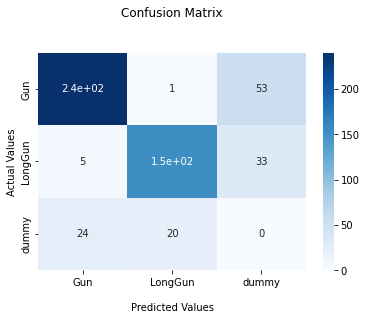

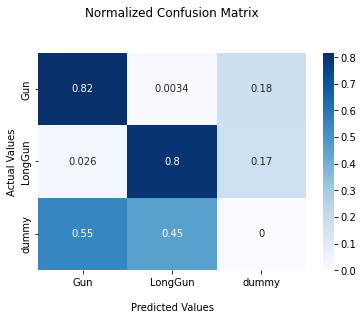

              precision    recall  f1-score   support
         Gun       0.89      0.82      0.85       294
     LongGun       0.88      0.80      0.84       191
Accuracy =  0.743
Average Precisison =  0.885
Average Recall =  0.81
Average F1-Score =  0.845


In [29]:
if not Direct_Detection:
    yolo_Matrix(0)
else:
    yolo_Matrix(valid_test=0,yolo_weights_path  = DP_Weights_Path)

#Test

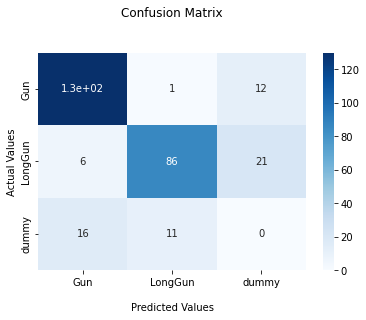

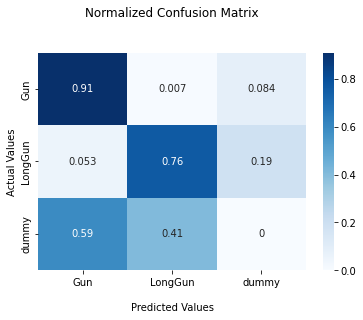

              precision    recall  f1-score   support
         Gun       0.86      0.91      0.88       143
     LongGun       0.88      0.76      0.82       113
Accuracy =  0.763
Average Precisison =  0.87
Average Recall =  0.835
Average F1-Score =  0.85


In [30]:
if not Direct_Detection:
    yolo_Matrix(1)
else:
    yolo_Matrix(valid_test=1,yolo_weights_path  = DP_Weights_Path)

# Show images

In [31]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
import shutil
try:
  if running_on_vm:
    shutil.rmtree('/content/YOLO/yolov5/runs/detect/exp')
    shutil.rmtree('/content/YOLO/yolov5/runs/detect/exp2')
    shutil.rmtree('/content/YOLO/yolov5/runs/detect/exp3')

  else:
    shutil.rmtree('/content/yolov5/runs/detect/exp')
    shutil.rmtree('/content/yolov5/runs/detect/exp2')
    shutil.rmtree('/content/yolov5/runs/detect/exp3')


except:
  No_Error = 0

if running_on_vm:
  %cd /content/YOLO/yolov5/
else:
  %cd /content/yolov5/

if not Direct_Detection:
    !python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img $YOLO_imgsize --conf 0.4 --source ../train/images --save-txt --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh --save-conf #--hide-labels  --hide-conf                            # or Ctrl + V
    !python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img $YOLO_imgsize --conf 0.4 --source ../valid/images --save-txt --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh --save-conf #--hide-labels  --hide-conf                            # or Ctrl + V
    !python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img $YOLO_imgsize --conf 0.4 --source ../test/images --save-txt --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh --save-conf #--hide-labels  --hide-conf                            # or Ctrl + V

else:
    !python detect.py --weights $DP_Weights_Path --img $YOLO_imgsize --conf 0.4 --source ../train/images --save-txt --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh --save-conf #--hide-labels --hide-conf                  # or Ctrl + V
    !python detect.py --weights $DP_Weights_Path --img $YOLO_imgsize --conf 0.4 --source ../valid/images --save-txt --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh --save-conf #--hide-labels --hide-conf                  # or Ctrl + V
    !python detect.py --weights $DP_Weights_Path --img $YOLO_imgsize --conf 0.4 --source ../test/images --save-txt --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh --save-conf #--hide-labels --hide-conf                  # or Ctrl + V




/content/YOLO/yolov5
detect: weights=['/content/drive/MyDrive/YoloWeights/Yolo5/yolo5s-2CWs320-trs320-vm7.pt'], source=../train/images, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.15, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1399 /content/YOLO/train/images/10002DL_jpg.rf.71d5d91ae5f3e7a58975151bd5c943ec.jpg: 320x320 1 LongGun, 23.9ms
image 2/1399 /content/YOLO/train/images/10025DL_jpg.rf.4bca082ff73c4c3053f66d3b2a972c1d.jpg: 320x320 1 LongGun, 16.9ms
image 3/1399 /content/

In [32]:
import os

path = mainfolderpath + '/SmallImages'
if not os.path.exists(path):
    os.makedirs(path)
else:
    shutil.rmtree(path)
    os.makedirs(path)

path = mainfolderpath + '/SmallImages/train/frames'
if not os.path.exists(path):
    os.makedirs(path)
else:
    shutil.rmtree(path)
    os.makedirs(path)
path = mainfolderpath + '/SmallImages/train/classes'
if not os.path.exists(path):
    os.makedirs(path)
else:
    shutil.rmtree(path)
    os.makedirs(path)
"""
path = mainfolderpath + '/SmallImages/train'
if not os.path.exists(path):
    os.makedirs(path)
else:
    shutil.rmtree(path)
    os.makedirs(path)
"""
path = mainfolderpath + '/SmallImages/valid'
if not os.path.exists(path):
    os.makedirs(path)
else:
    shutil.rmtree(path)
    os.makedirs(path)

path = mainfolderpath + '/SmallImages/test'
if not os.path.exists(path):
    os.makedirs(path)
else:
    shutil.rmtree(path)
    os.makedirs(path)

In [33]:
k = -1

In [34]:
for file_name in os.listdir(mainfolderpath + '/yolov5/runs/detect/exp'):
  if file_name == 'labels':
      continue
  k = k+1
  file_path = os.path.join(mainfolderpath + '/train/images',file_name)
  img_shape = cv2.imread(file_path).shape
  txt_path = os.path.join(mainfolderpath + '/yolov5/runs/detect/exp/labels',file_name[:-3]+"txt")
  #path = mainfolderpath + '/SmallImages/train/'
  path = mainfolderpath + '/SmallImages/train/frames/'
  path2 = mainfolderpath + '/SmallImages/train/classes/'

  cv2.imwrite(path + '/' + str(k) + '_.jpg', cv2.imread(mainfolderpath + '/yolov5/runs/detect/exp/'+ file_name))

  try:
    classes,xmin,xmax,ymin,ymax = extract_images(txt_path,img_shape)
  except:
    continue
  i = 0
  for sub_img in xmin:
    im = cv2.imread(file_path)
    im = im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]
    down_points = (240, 240)
    im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
    #cv2.imwrite(path + '/' + str(k) + '_' + str(i) + '.jpg', im)
    cv2.imwrite(path2 + '/' + str(k) + '_' + str(i) + '.jpg', im)
    i = i+1


In [35]:
for file_name in os.listdir(mainfolderpath + '/yolov5/runs/detect/exp2'):
  if file_name == 'labels':
      continue
  k = k+1
  file_path = os.path.join(mainfolderpath + '/valid/images',file_name)
  img_shape = cv2.imread(file_path).shape
  txt_path = os.path.join(mainfolderpath + '/yolov5/runs/detect/exp2/labels',file_name[:-3]+"txt")
  path = mainfolderpath + '/SmallImages/valid/'
  cv2.imwrite(path + '/' + str(k) + '_.jpg', cv2.imread(mainfolderpath + '/yolov5/runs/detect/exp2/'+ file_name))
  try:
    classes,xmin,xmax,ymin,ymax = extract_images(txt_path,img_shape)
  except:
    continue
  i = 0
  for sub_img in xmin:
    im = cv2.imread(file_path)
    im = im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]
    down_points = (240, 240)
    im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
    cv2.imwrite(path + '/' + str(k) + '_' + str(i) + '.jpg', im)
    i = i+1

In [36]:
for file_name in os.listdir(mainfolderpath + '/yolov5/runs/detect/exp3'):
  if file_name == 'labels':
      continue
  k = k+1
  file_path = os.path.join(mainfolderpath + '/test/images',file_name)
  img_shape = cv2.imread(file_path).shape
  txt_path = os.path.join(mainfolderpath + '/yolov5/runs/detect/exp3/labels',file_name[:-3]+"txt")
  path = mainfolderpath + '/SmallImages/test/'
  cv2.imwrite(path + '/' + str(k) + '_.jpg', cv2.imread(mainfolderpath + '/yolov5/runs/detect/exp3/'+ file_name))
  try:
    classes,xmin,xmax,ymin,ymax = extract_images(txt_path,img_shape)
  except:
    continue
  i = 0
  for sub_img in xmin:
    im = cv2.imread(file_path)
    im = im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]
    down_points = (240, 240)
    im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
    cv2.imwrite(path + '/' + str(k) + '_' + str(i) + '.jpg', im)
    i = i+1

In [37]:
#shutil.make_archive(mainfolderpath + "/YOLO-IMAGES-Train", 'zip', mainfolderpath + '/SmallImages/train')
shutil.make_archive(mainfolderpath + "/YOLO-IMAGES-Train-frames", 'zip', mainfolderpath + '/SmallImages/train/frames')
shutil.make_archive(mainfolderpath + "/YOLO-IMAGES-Train-classes", 'zip', mainfolderpath + '/SmallImages/train/classes')
shutil.make_archive(mainfolderpath + "/YOLO-IMAGES-Valid", 'zip', mainfolderpath + '/SmallImages/valid')
shutil.make_archive(mainfolderpath + "/YOLO-IMAGES-Test", 'zip', mainfolderpath + '/SmallImages/test')

'/content/YOLO/YOLO-IMAGES-Test.zip'

In [ ]:
import glob
from IPython.display import Image, display

globpath=''
resultlabelpath=''

if running_on_vm:
  globpath='/content/YOLO/yolov5/runs/detect/exp/*.jpg'
  resultlabelpath='/content/YOLO/yolov5/runs/detect/exp/labels/'
else:
  globpath='/content/yolov5/runs/detect/exp/*.jpg'
  resultlabelpath='/content/yolov5/runs/detect/exp/labels/'

for imageName in glob.glob(globpath): #assuming JPG
    image_result = "found instance of classes:  "
    try:
      with open(resultlabelpath + imageName.split('/')[-1][:-3]+'txt') as infile:
        lines = infile.readlines()
      for line in line:
        print(line)
        image_result = image_result + class_names[int(line.split(" ")[0])] + "  ,  "
    except:
      image_result = "No instances"
    #print(image_result)
    display(Image(filename=imageName))
    print("\n")

In [39]:
import datetime
tme = datetime.datetime.utcnow()+datetime.timedelta(hours=2)
print(tme.strftime('%H:%M:%S'))